## Load Dataset

In [162]:
import pandas as pd
import numpy as np

df = pd.read_csv(
    r"C:\Users\DELL\Desktop\Datasets\pathologies.csv",
    sep=";",
    encoding="latin-1"
)


## Extract raw text values from val column

In [165]:
raw_vals = df["val"].astype(str)

## Clean scientific notation

In [168]:
mask_sci = raw_vals.str.contains(r'[Ee]', case=False)

df.loc[mask_sci, "val"] = (
    raw_vals[mask_sci]
    .str.replace(",", ".", regex=False)
    .astype(float)
)

## Clean dot-separated huge numbers

In [171]:
mask_thousands = raw_vals.str.fullmatch(r'\d{1,3}(?:\.\d{3})+')

df.loc[mask_thousands, "val"] = (
    raw_vals[mask_thousands]
    .str.replace(".", "", regex=False)
    .astype(float)
)


## Clean normal decimals

In [174]:
mask_decimal = ~(mask_sci | mask_thousands)

df.loc[mask_decimal, "val"] = raw_vals[mask_decimal].astype(float)


## Split the metrics into separate columns

In [177]:
df["Percent"] = np.where(df["metric"] == "Percent", df["val"], np.nan)
df["Number"]  = np.where(df["metric"] == "Number",  df["val"], np.nan)
df["Rate"]    = np.where(df["metric"] == "Rate",    df["val"], np.nan)

## Convert all new columns to float

In [180]:
df["Percent"] = pd.to_numeric(df["Percent"], errors="coerce")
df["Number"]  = pd.to_numeric(df["Number"],  errors="coerce")
df["Rate"]    = pd.to_numeric(df["Rate"],    errors="coerce")

## Clean Percent values properly

In [183]:
p = df["Percent"]

# Fix huge values caused by scientific notation
df.loc[p > 100, "Percent"] = p[p > 100] / 10

# Fix tiny decimals like 0.004 → 0.4%
df.loc[(p > 0) & (p < 1), "Percent"] = p[(p > 0) & (p < 1)] * 100

# Final bound (0 to 100)
df["Percent"] = df["Percent"].clip(0, 100)


## Clean Number values

In [186]:
n = df["Number"]

df.loc[(n > 1e12), "Number"] = n[n > 1e12] / 1e6
df.loc[(n > 1e9),  "Number"] = n[n > 1e9]  / 1e3

## Clean Rate values

In [189]:
r = df["Rate"]

df.loc[(r > 1e12), "Rate"] = r[r > 1e12] / 1e6
df.loc[(r > 1e9),  "Rate"] = r[r > 1e9]  / 1e3

## Drop the original val + metric columns

In [206]:
# Rebuild percent properly BEFORE pivot

p = df["Percent"]

# Case 1: Extremely large values (scientific notation originally)
df.loc[(p > 1000), "Percent"] = p[p > 1000] / 1e10

# Case 2: Large but not insane (100–1000 range)
df.loc[(p >= 100) & (p <= 1000), "Percent"] = p[(p >= 100) & (p <= 1000)] / 10

# Case 3: Tiny decimals (< 0.5)
df.loc[(p > 0) & (p < 0.5), "Percent"] = p[(p > 0) & (p < 0.5)] * 100

# Ensure valid range
df["Percent"] = df["Percent"].clip(0, 100)


In [208]:
df_final = df.pivot_table(
    index=["country", "ISO-2", "measure", "age", "cause", "year"],
    values=["Percent", "Number", "Rate"],
    aggfunc="first"
).reset_index()


In [212]:
# Fix Number
n = df_final["Number"]
df_final.loc[n > 1e8, "Number"] = n[n > 1e8] / 1e2

# Fix Rate
r = df_final["Rate"]
df_final.loc[r > 1e8, "Rate"] = r[r > 1e8] / 1e2


In [214]:
df_final.head(20)
df_final.describe()


,year,Number,Percent,Rate
count,33360.000000,3.336000e+04,33360.000000,3.336000e+04
mean,2014.500000,1.011393e+07,7.732954,9.632560e+06
std,2.872324,1.160089e+07,7.099458,1.187033e+07
min,2010.000000,0.000000e+00,0.000000,0.000000e+00
25%,2012.000000,2.905145e+06,1.000000,3.096040e+06
50%,2014.500000,6.160324e+06,9.235005,5.586450e+06
75%,2017.000000,1.269916e+07,10.000000,1.038217e+07
max,2019.000000,9.996292e+07,49.736156,9.999913e+07


In [216]:
df_final.to_csv(
    r"C:\Users\DELL\Desktop\Datasets\pathologies_clean_final.csv",
    index=False
)


## Exploratory Data Analysis

In [219]:
import pandas as pd
import numpy as np

path = r"C:\Users\DELL\Desktop\Datasets\pathologies_clean_final.csv"
df = pd.read_csv(path)

# basic shape & types
print("shape:", df.shape)
print(df.dtypes)

# global summary
summary = df.describe(include='all')
print(summary)

# missing values
print("missing per column:\n", df.isna().sum())

# unique counts for key categoricals
print("unique countries:", df['country'].nunique())
print("unique causes:", df['cause'].nunique())
print("years:", sorted(df['year'].unique()))

# top causes overall by Number, sum across years & countries
top_causes = df.groupby('cause', dropna=False)['Number'].sum().sort_values(ascending=False).head(20)
print("top causes by total Number:\n", top_causes)

# top countries by total Number
top_countries = df.groupby('country')['Number'].sum().sort_values(ascending=False).head(20)
print("top countries by Number:\n", top_countries)

# Time trends (global mean Number, Percent by year)
trend_year = df.groupby('year').agg({
    'Number': 'sum',
    'Percent': 'mean',
    'Rate': 'mean'
}).reset_index()
print("year trend:\n", trend_year)

# Age-group contribution sample
age_contrib = df.groupby('age')['Number'].sum().sort_values(ascending=False)
print("age contributions:\n", age_contrib)

shape: (33360, 9)
country     object
ISO-2       object
measure     object
age         object
cause       object
year         int64
Number     float64
Percent    float64
Rate       float64
dtype: object
       country  ISO-2    measure      age       cause          year  \
count    33360  33360      33360    33360       33360  33360.000000   
unique     203    203          1        2          10           NaN   
top      India     IN  Incidence  5 to 19  All causes           NaN   
freq       200    200      33360    16680        4060           NaN   
mean       NaN    NaN        NaN      NaN         NaN   2014.500000   
std        NaN    NaN        NaN      NaN         NaN      2.872324   
min        NaN    NaN        NaN      NaN         NaN   2010.000000   
25%        NaN    NaN        NaN      NaN         NaN   2012.000000   
50%        NaN    NaN        NaN      NaN         NaN   2014.500000   
75%        NaN    NaN        NaN      NaN         NaN   2017.000000   
max        NaN  

## Visualizations

##### Global Number trend (sum by year)

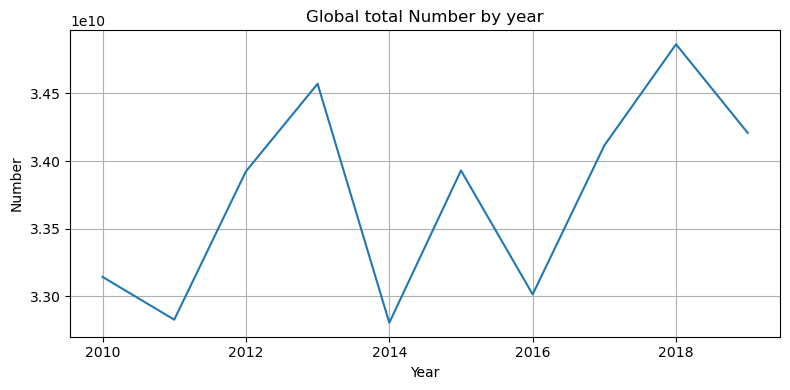

In [222]:
import matplotlib.pyplot as plt
agg = df.groupby('year')['Number'].sum()
plt.figure(figsize=(8,4))
plt.plot(agg.index, agg.values)
plt.title("Global total Number by year")
plt.xlabel("Year")
plt.ylabel("Number")
plt.grid(True)
plt.tight_layout()
plt.show()

##### Top 10 causes (total Number)

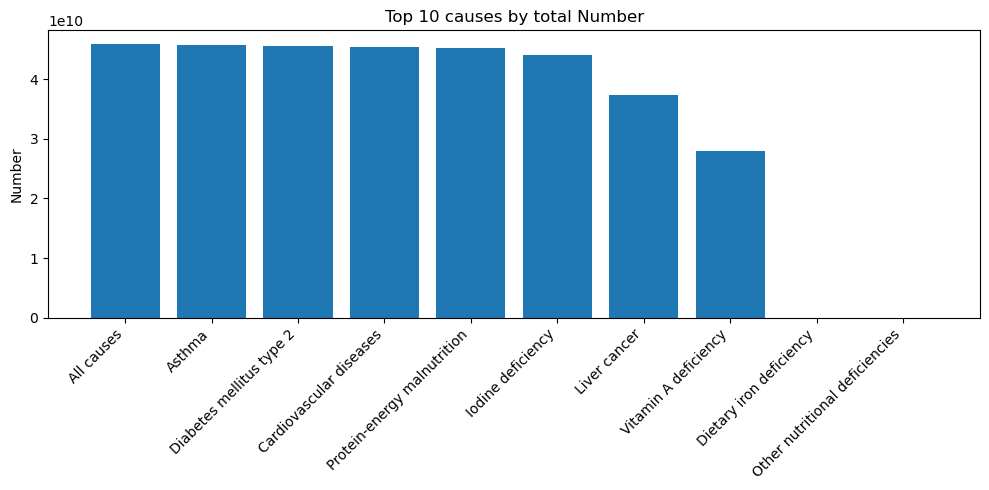

In [224]:
top10 = df.groupby('cause')['Number'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
plt.bar(top10.index, top10.values)
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 causes by total Number")
plt.ylabel("Number")
plt.tight_layout()
plt.show()

##### Percent distribution (histogram)

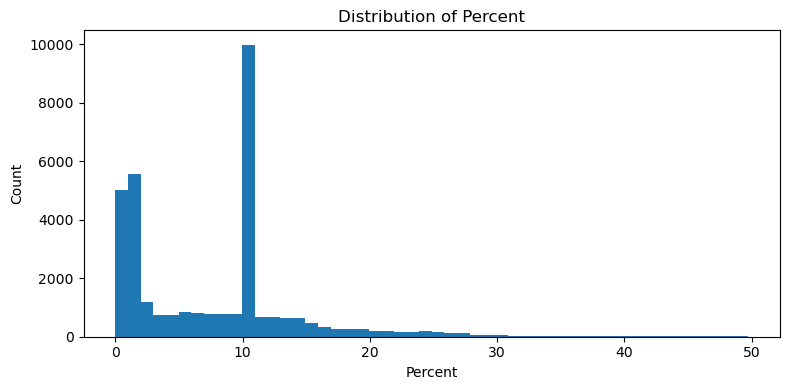

In [226]:
plt.figure(figsize=(8,4))
plt.hist(df['Percent'].dropna(), bins=50)
plt.title("Distribution of Percent")
plt.xlabel("Percent")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


##### Country trend for a chosen country 

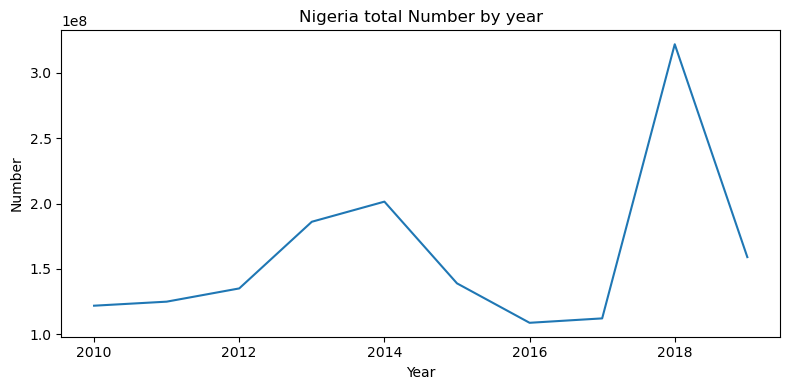

In [228]:
country_name = "Nigeria"
c_df = df[df['country']==country_name].groupby('year')['Number'].sum()
plt.figure(figsize=(8,4))
plt.plot(c_df.index, c_df.values)
plt.title(f"{country_name} total Number by year")
plt.xlabel("Year")
plt.ylabel("Number")
plt.tight_layout()
plt.show()

##### Fastest Growing Diseases Over Time

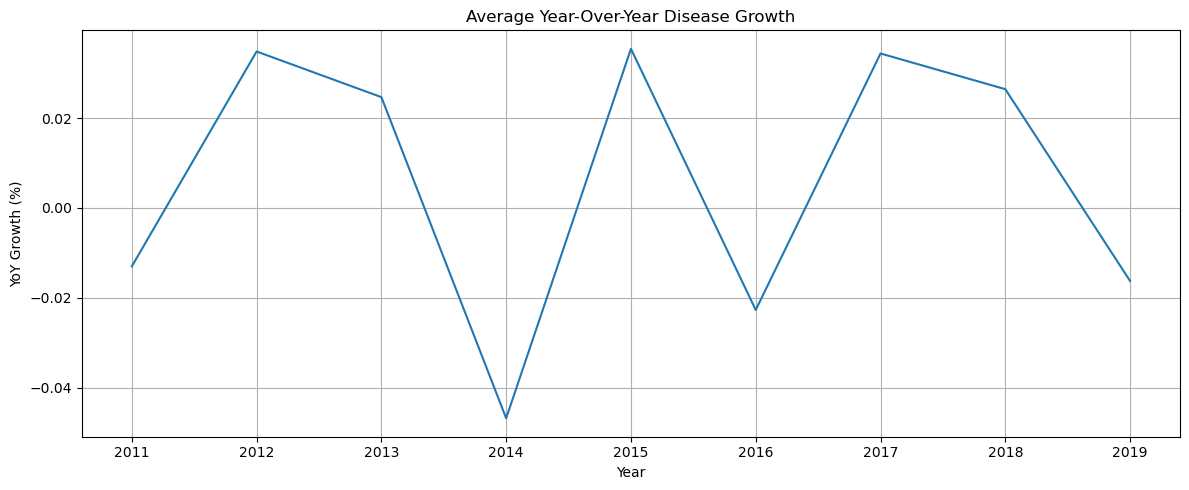

In [231]:
growth = (
    df.groupby(['cause', 'year'])['Number']
    .sum()
    .groupby(level=0)
    .pct_change()
    .reset_index()
)

pivot = growth.pivot(index='year', columns='cause', values='Number')

plt.figure(figsize=(12,5))
plt.plot(pivot.index, pivot.mean(axis=1))
plt.title("Average Year-Over-Year Disease Growth")
plt.xlabel("Year")
plt.ylabel("YoY Growth (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


##### Top 10 Diseases by Growth (2010 → 2019)

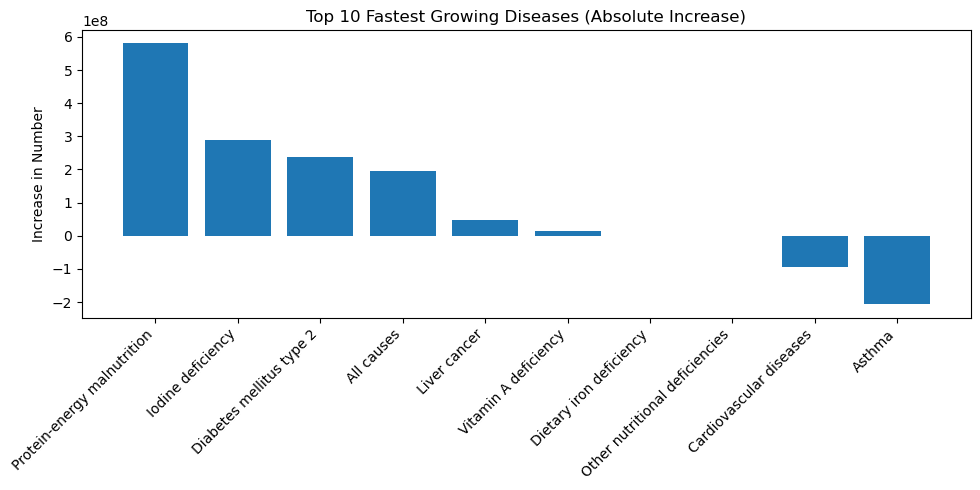

In [238]:
start = df[df['year']==2010].groupby('cause')['Number'].sum()
end   = df[df['year']==2019].groupby('cause')['Number'].sum()

growth_abs = (end - start).sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
plt.bar(growth_abs.index, growth_abs.values)
plt.title("Top 10 Fastest Growing Diseases (Absolute Increase)")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Increase in Number")
plt.tight_layout()
plt.show()

##### Disease Percent Distribution per Cause

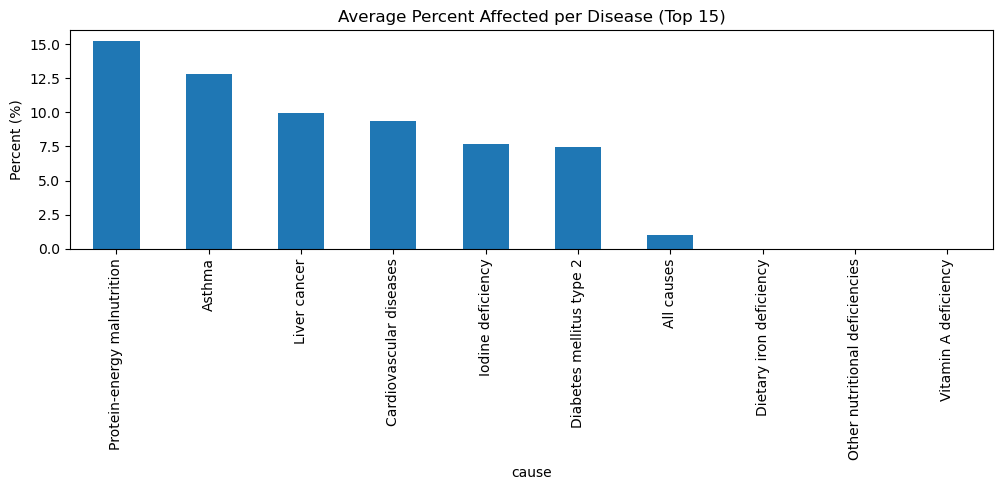

In [244]:
plt.figure(figsize=(10,5))
df.groupby('cause')['Percent'].mean().sort_values(ascending=False).head(15).plot(kind='bar')
plt.title("Average Percent Affected per Disease (Top 15)")
plt.ylabel("Percent (%)")
plt.tight_layout()
plt.show()

##### Age Group Vulnerability Chart

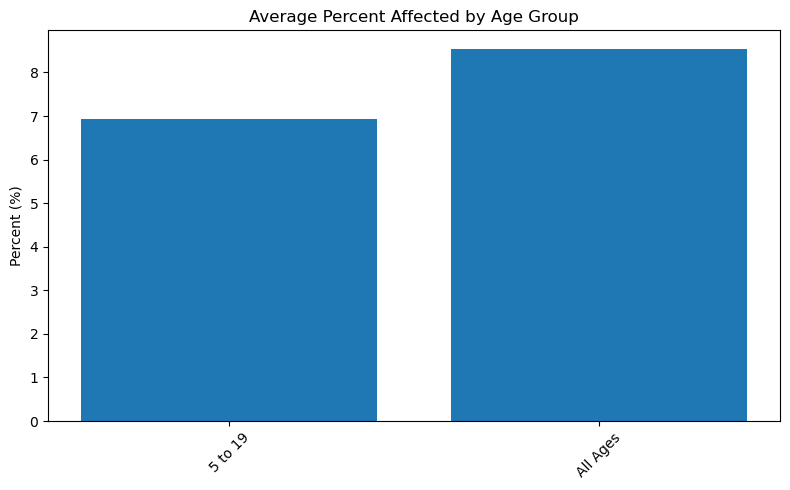

In [247]:
age_burden = df.groupby('age')['Percent'].mean().sort_values()

plt.figure(figsize=(8,5))
plt.bar(age_burden.index, age_burden.values)
plt.title("Average Percent Affected by Age Group")
plt.ylabel("Percent (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Compare Two Countries (Side-by-Side Trend)

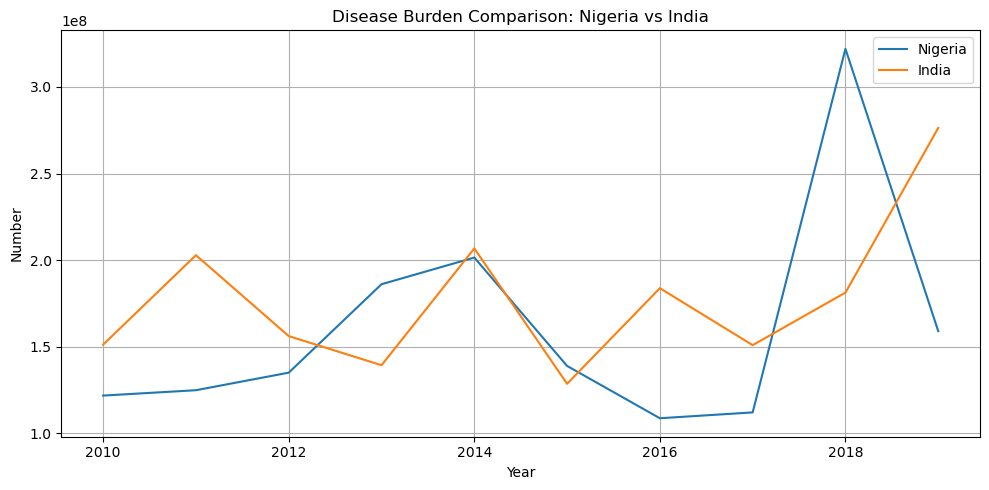

In [253]:
country_a = "Nigeria"
country_b = "India"

df_a = df[df['country']==country_a].groupby('year')['Number'].sum()
df_b = df[df['country']==country_b].groupby('year')['Number'].sum()

plt.figure(figsize=(10,5))
plt.plot(df_a.index, df_a.values, label=country_a)
plt.plot(df_b.index, df_b.values, label=country_b)
plt.legend()
plt.title(f"Disease Burden Comparison: {country_a} vs {country_b}")
plt.xlabel("Year")
plt.ylabel("Number")
plt.grid(True)
plt.tight_layout()
plt.show()

##### Top Diseases Per Country

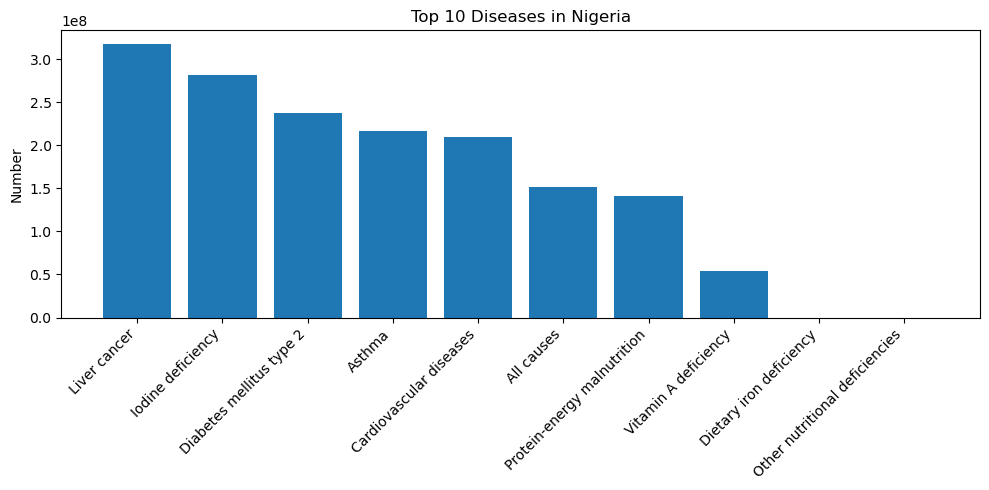

In [256]:
country = "Nigeria"

top_causes_country = (
    df[df['country']==country]
    .groupby('cause')['Number']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10,5))
plt.bar(top_causes_country.index, top_causes_country.values)
plt.xticks(rotation=45, ha='right')
plt.title(f"Top 10 Diseases in {country}")
plt.ylabel("Number")
plt.tight_layout()
plt.show()

##### Rate Trend Over Time

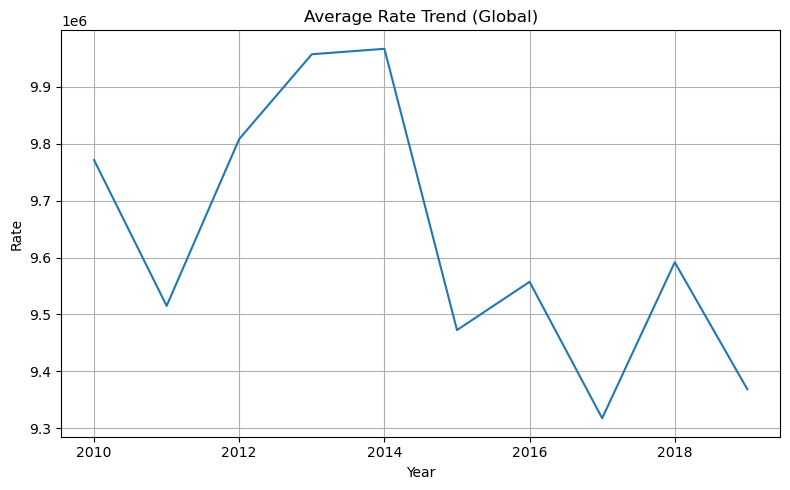

In [260]:
rate_trend = df.groupby('year')['Rate'].mean()

plt.figure(figsize=(8,5))
plt.plot(rate_trend.index, rate_trend.values)
plt.title("Average Rate Trend (Global)")
plt.xlabel("Year")
plt.ylabel("Rate")
plt.grid(True)
plt.tight_layout()
plt.show()

##### Outlier Detection (Boxplot per Cause)

<Figure size 1400x500 with 0 Axes>

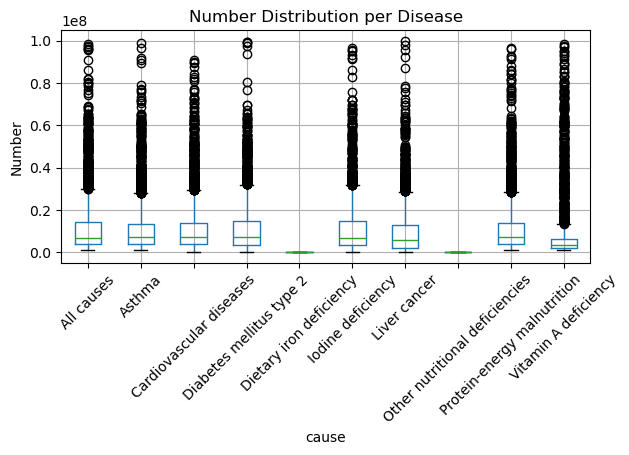

In [263]:
plt.figure(figsize=(14,5))
df.boxplot(column='Number', by='cause', rot=45)
plt.title("Number Distribution per Disease")
plt.suptitle("")  # remove default pandas title
plt.ylabel("Number")
plt.tight_layout()
plt.show()